In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [50]:
data = pd.read_csv('data.csv')

In [51]:
data.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [52]:
data.shape

(461, 17)

In [53]:
data.isnull().sum()

name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_value       0
fpl_sel         0
fpl_points      0
region          1
nationality     0
new_foreign     0
age_cat         0
club_id         0
big_club        0
new_signing     0
dtype: int64

In [54]:
data = data.dropna()

In [55]:
data.isnull().sum().sum()

0

<AxesSubplot:>

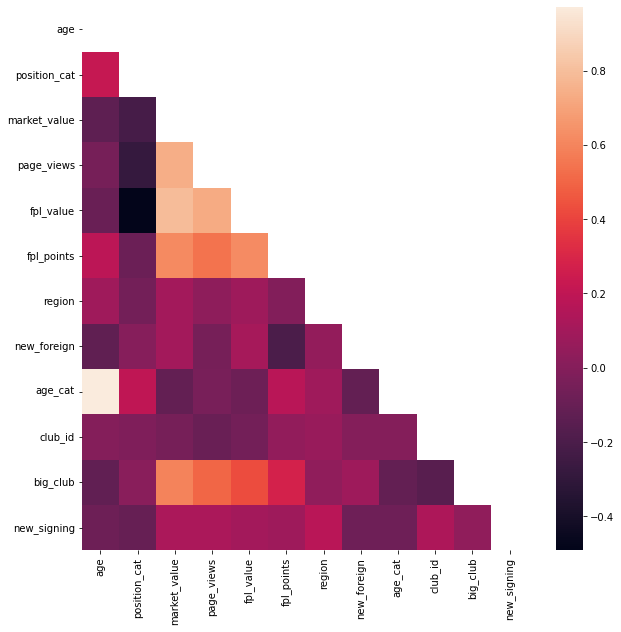

In [56]:
sample = data.select_dtypes(include='number')
corr = sample.corr()
mask = np.zeros_like(corr, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask)

In [57]:
scaled = StandardScaler()
X = scaled.fit_transform(sample)
recommendations = NearestNeighbors(n_neighbors = 5, algorithm='kd_tree')
recommendations.fit(X)
player_index = recommendations.kneighbors(X)[1]

In [58]:
def find_index(x):
    return data[data['name']==x].index.tolist()[0]

def recommendation_system(player):
    print("Here are four players who are similar to {}: ".format(player))
    index =  find_index(player)
    for i in player_index[index][1:]:
        print("Player Name: {}\nPlayer Market Value: €{}\nPlayer Age: {}\nPlayer Current Club: {}\n".format(data.iloc[i]['name'],
                                                                                        data.iloc[i]['market_value'], 
                                                                                        data.iloc[i]['age'], 
                                                                                        data.iloc[i]['club']))

In [59]:
recommendation_system('Petr Cech')

Here are four players who are similar to Petr Cech: 
Player Name: Willy Caballero
Player Market Value: €1.5
Player Age: 35
Player Current Club: Chelsea

Player Name: Nacho Monreal
Player Market Value: €13.0
Player Age: 31
Player Current Club: Arsenal

Player Name: Laurent Koscielny
Player Market Value: €22.0
Player Age: 31
Player Current Club: Arsenal

Player Name: Artur Boruc
Player Market Value: €1.0
Player Age: 37
Player Current Club: Bournemouth

